In [213]:
from typing import List, Optional, Union, Tuple, Dict, Any

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import NaiveDrift, ARIMA, ExponentialSmoothing
from darts.dataprocessing.transformers import Diff, BoxCox
from darts.utils.statistics import stationarity_test_adf, extract_trend_and_seasonality, plot_acf, plot_pacf
from darts.metrics.metrics import mae, mape, rmse, smape

In [160]:
df_train = pd.read_csv("../data/train.csv", parse_dates=["timestamp"])
df_val = pd.read_csv("../data/validate.csv")
df_test = pd.read_csv("../data/test.csv")

In [161]:
df_low_train = df_train["low"]
ts_train = TimeSeries.from_series(df_low_train) 
df_low_val = df_val["low"]
ts_val = TimeSeries.from_series(df_low_val) 
df_low_test = df_test["low"]
ts_test = TimeSeries.from_series(df_low_test) 

print(ts_train.shape)
print(ts_val.shape)
print(ts_test.shape)

(24813, 1, 1)
(7800, 1, 1)
(7409, 1, 1)


In [184]:
def plot_consecutive_series(
    ax: plt.Axes,
    series_list: List[pd.Series],
    color: str,
    label: str,
    starting_points: Optional[List[int]] = None,
    linewidth: float = 2.0,
    alpha: float = 1.0,
    linestyle: str = '-'
) -> None:
    """
    Plot consecutive series (Type 1) that span different time ranges with proper indexing.
    
    Parameters:
    -----------
    ax : plt.Axes
        Matplotlib axes to plot on
    series_list : List[pd.Series]
        List of consecutive series to plot
    color : str
        Color for the series
    label : str
        Label for the series
    starting_points : List[int], optional
        Starting indices for each series. If None, will append each series after the previous one.
        If provided, must be the same length as series_list.
    linewidth : float
        Width of plot lines
    alpha : float
        Transparency level
    linestyle : str
        Style of the line
    """
    if starting_points is None:
        # Auto-calculate starting points by appending series
        starting_points = []
        current_x = 0
        for series in series_list:
            starting_points.append(current_x)
            current_x += len(series)
    
    # Ensure we have the correct number of starting points
    if len(starting_points) != len(series_list):
        raise ValueError(f"Number of starting points ({len(starting_points)}) must match number of series ({len(series_list)})")
    
    # Plot each series, with appropriate x positions
    for i, (series, start) in enumerate(zip(series_list, starting_points)):
        x = np.arange(start, start + len(series))
        
        # Only use the label for the first segment to avoid duplicate legend entries
        current_label = label if i == 0 else "_nolegend_"
        
        ax.plot(x, series.values, color=color, label=current_label,
               linewidth=linewidth, alpha=alpha, linestyle=linestyle)

def plot_overlapping_series(
    ax: plt.Axes,
    series_list: List[pd.Series],
    color: str,
    base_label: str,
    starting_point: int = 0,
    linewidth: float = 2.0,
    alpha: float = 1.0,
    linestyle: str = '-',
    variant_naming: bool = True
) -> None:
    """
    Plot overlapping prediction series (Type 2) that span the same time range.
    
    Parameters:
    -----------
    ax : plt.Axes
        Matplotlib axes to plot on
    series_list : List[pd.Series]
        List of prediction series to plot
    color : str
        Base color for the series
    base_label : str
        Base label for the series
    starting_point : int
        Starting index for the prediction series (e.g., where validation starts)
    linewidth : float
        Width of plot lines
    alpha : float
        Transparency level
    linestyle : str
        Style of the line
    variant_naming : bool
        If True, add variant numbers to labels
    """
    # Ensure all series have the same length
    lengths = [len(s) for s in series_list]
    if len(set(lengths)) > 1:
        print(f"Warning: Prediction series have different lengths: {lengths}")
    
    # Plot each prediction series
    for i, series in enumerate(series_list):
        x = np.arange(starting_point, starting_point + len(series))
        
        # Create the label with variant numbering if needed
        if variant_naming and len(series_list) > 1:
            label = f"{base_label} {i+1}" if i > 0 else base_label
        else:
            label = base_label if i == 0 else f"{base_label} (variant {i+1})"
        
        ax.plot(x, series.values, color=color, label=label,
               linewidth=linewidth, alpha=alpha, linestyle=linestyle)

def plot_series(
    series_data: List[Union[pd.Series, Tuple[pd.Series, int], List[pd.Series], 
                           Tuple[List[pd.Series], str], Tuple[List[pd.Series], str, List[int]],
                           Tuple[List[pd.Series], str, int]]],
    colors: List[str],
    labels: List[str],
    title: Optional[str] = None,
    figsize: Tuple[int, int] = (12, 6),
    linewidth: float = 2.0,
    grid: bool = True,
    legend_loc: str = 'best',
    xlabel: Optional[str] = 'Time',
    ylabel: Optional[str] = 'Value',
    save_path: Optional[str] = None,
    alpha: float = 1.0,
    linestyles: Optional[List[str]] = None,
    **kwargs: Dict[str, Any]
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Main plotting function that combines both types of series plotting with proper indexing.
    
    Parameters:
    -----------
    series_data : List of series items
        Each item can be:
        - pd.Series: A single series starting at index 0
        - Tuple[pd.Series, int]: A single series with a starting index
        - List[pd.Series]: Either Type 1 (consecutive) or Type 2 (overlapping)
        - Tuple[List[pd.Series], str]: Series list with type ('consecutive' or 'overlapping')
        - Tuple[List[pd.Series], str, List[int]]: Consecutive series with starting points
        - Tuple[List[pd.Series], str, int]: Overlapping series with a starting point
    colors : List of str
        Colors for each series or group of series
    labels : List of str
        Labels for each series or group of series
    Other parameters are the same as in previous functions
    
    Returns:
    --------
    fig, ax : The matplotlib figure and axis objects
    """
    fig, ax = plt.subplots(figsize=figsize, **kwargs)
    
    if linestyles is None:
        linestyles = ['-'] * len(series_data)
    
    # Process each series or group of series
    for i, item in enumerate(series_data):
        current_color = colors[i] if i < len(colors) else f"C{i}"
        current_label = labels[i] if i < len(labels) else f"Series {i+1}"
        current_style = linestyles[i] if i < len(linestyles) else '-'
        
        # Handle different input formats
        if isinstance(item, tuple):
            if len(item) == 2:
                if isinstance(item[0], pd.Series):
                    # Single series with starting point: (series, start_idx)
                    series, start_idx = item
                    plot_consecutive_series(ax, [series], current_color, current_label, 
                                          [start_idx], linewidth, alpha, current_style)
                else:
                    # Series list with type: (series_list, type_str)
                    series_list, plot_type = item
                    if plot_type.lower() == 'consecutive':
                        plot_consecutive_series(ax, series_list, current_color, current_label, 
                                              None, linewidth, alpha, current_style)
                    elif plot_type.lower() == 'overlapping':
                        plot_overlapping_series(ax, series_list, current_color, current_label, 
                                              0, linewidth, alpha, current_style)
                    else:
                        raise ValueError(f"Unknown plot type: {plot_type}")
            elif len(item) == 3:
                # Series list with type and starting info: (series_list, type_str, start_info)
                series_list, plot_type, start_info = item
                if plot_type.lower() == 'consecutive':
                    # For consecutive type, start_info should be a list of starting points
                    if isinstance(start_info, list):
                        plot_consecutive_series(ax, series_list, current_color, current_label, 
                                              start_info, linewidth, alpha, current_style)
                    else:
                        raise ValueError("For consecutive series, starting points should be a list")
                elif plot_type.lower() == 'overlapping':
                    # For overlapping type, start_info should be a single starting point
                    if isinstance(start_info, (int, float)):
                        plot_overlapping_series(ax, series_list, current_color, current_label, 
                                              start_info, linewidth, alpha, current_style)
                    else:
                        raise ValueError("For overlapping series, starting point should be a single value")
                else:
                    raise ValueError(f"Unknown plot type: {plot_type}")
                
        elif isinstance(item, list):
            # List of series - treat as Type 2 (overlapping predictions) by default
            plot_overlapping_series(ax, item, current_color, current_label, 
                                  0, linewidth, alpha, current_style)
                
        else:
            # Single series starting at 0 - treat as Type 1
            plot_consecutive_series(ax, [item], current_color, current_label, 
                                  [0], linewidth, alpha, current_style)
    
    # Set the plot attributes
    if title:
        ax.set_title(title, fontsize=14)
    
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=12)
    
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=12)
    
    if grid:
        ax.grid(True, linestyle='--', alpha=0.7)
    
    ax.legend(loc=legend_loc, frameon=True, fontsize=10)
    
    plt.tight_layout()
    
    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig, ax

In [205]:
def evaluation(actual, pred):
    result = {}
    result["MAE"] = mae(actual, pred)
    result["RMSE"] = rmse(actual, pred)
    result["MAPE"] = mape(actual, pred)
    result["SMAPE"] = smape(actual, pred)
    return result

(<Figure size 1200x600 with 1 Axes>, <Axes: xlabel='Time', ylabel='Value'>)

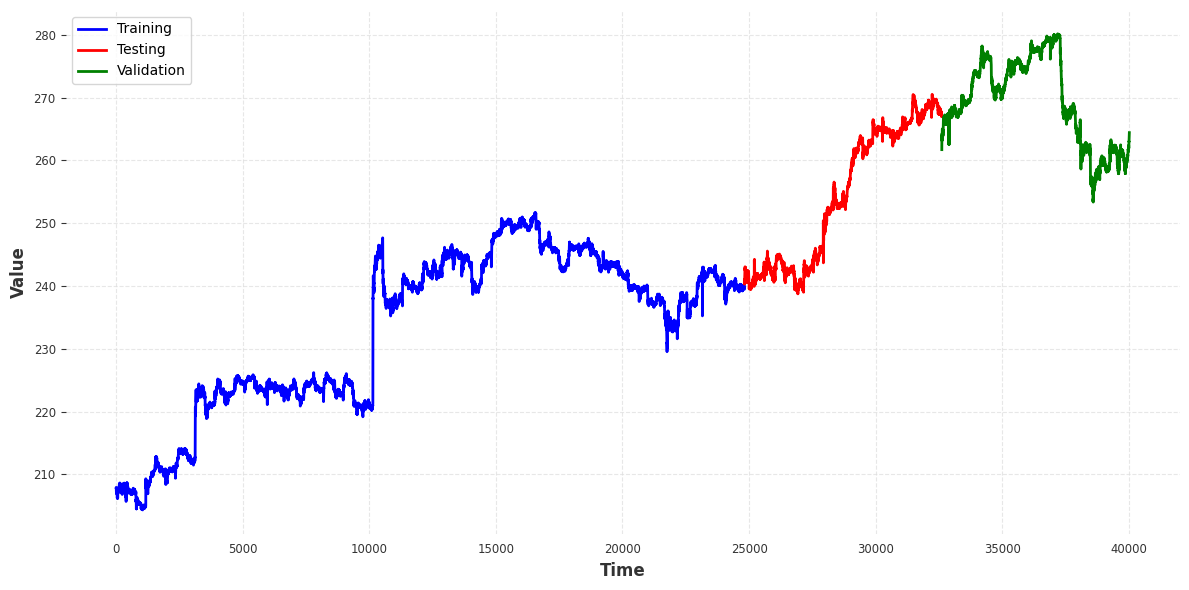

In [199]:
plot_series(
    [
        ts_train.pd_series(),                      
        (ts_val.pd_series(), ts_train.pd_series().shape[0]),               
        (ts_test.pd_series(), ts_train.pd_series().shape[0] + ts_val.pd_series().shape[0]),                        
        # ([model1_pred, model2_pred], 'overlapping', 8) 
    ],
    colors=['blue', 'red', 'green', 'purple'],
    labels=['Training', 'Testing', 'Validation', 'Predictions']
)

In [201]:
model = NaiveDrift()
model.fit(ts_train)
pred = model.predict(ts_val.shape[0])

(<Figure size 1200x600 with 1 Axes>, <Axes: xlabel='Time', ylabel='Value'>)

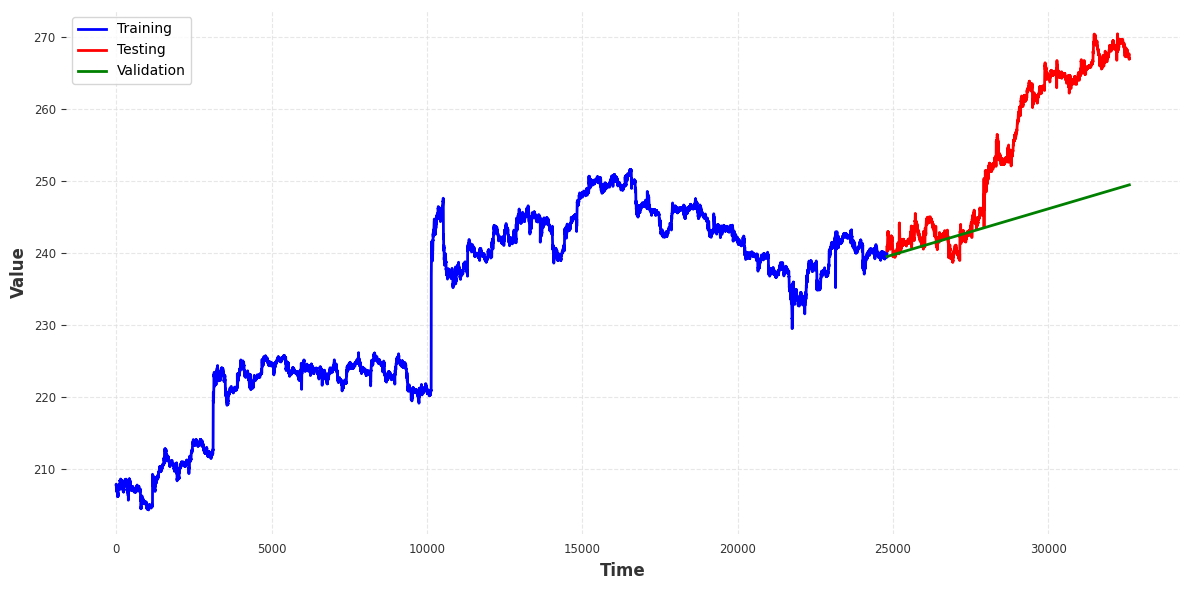

In [203]:
plot_series(
    [
        ts_train.pd_series(),                      
        (ts_val.pd_series(), ts_train.pd_series().shape[0]),               
        # (ts_test.pd_series(), ts_train.pd_series().shape[0] + ts_val.pd_series().shape[0]),                        
        ([pred.pd_series()], 'overlapping', ts_train.pd_series().shape[0]) 
    ],
    colors=['blue', 'red', 'green', 'purple'],
    labels=['Training', 'Testing', 'Validation', 'Predictions']
)

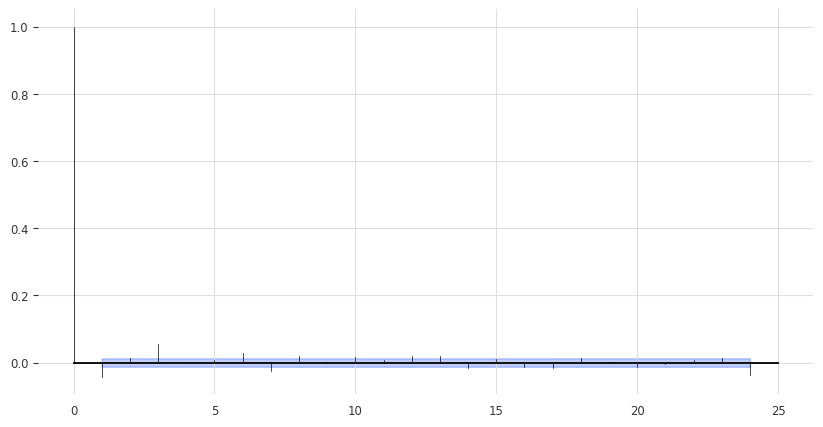

In [207]:
plot_acf(Diff(lags=1).fit_transform(ts_train))

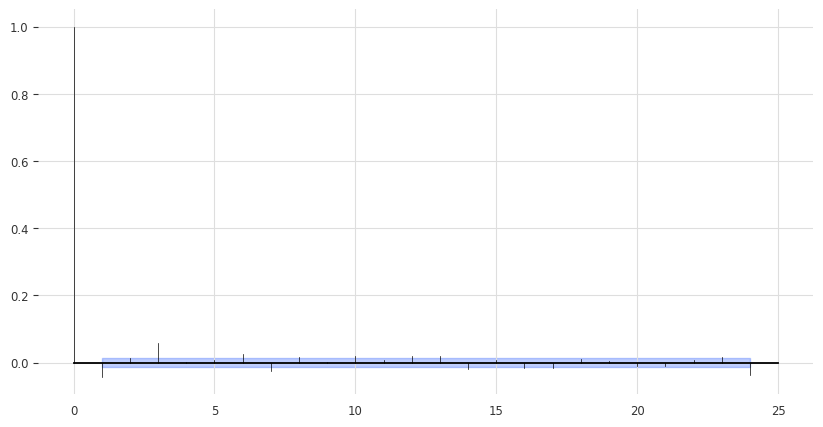

In [208]:
plot_pacf(Diff(lags=1).fit_transform(ts_train))

In [211]:
model = ARIMA(d=1, p=2, q=2)
model.fit(ts_train)
pred = model.predict(ts_val.shape[0])

(<Figure size 1200x600 with 1 Axes>, <Axes: xlabel='Time', ylabel='Value'>)

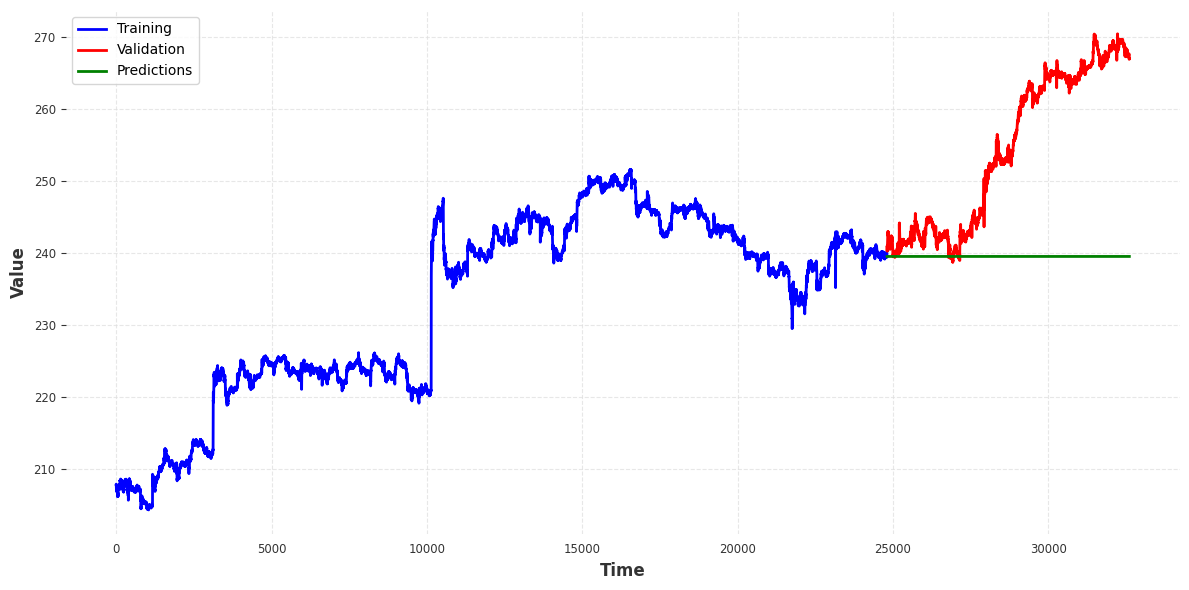

In [212]:
plot_series(
    [
        ts_train.pd_series(),                      
        (ts_val.pd_series(), ts_train.pd_series().shape[0]),                                    
        ([pred.pd_series()], 'overlapping', ts_train.pd_series().shape[0]) 
    ],
    colors=['blue', 'red', 'green'],
    labels=['Training', 'Validation', 'Predictions']
)

In [214]:
model = ExponentialSmoothing()
model.fit(ts_train)
pred = model.predict(ts_val.shape[0])

(<Figure size 1200x600 with 1 Axes>, <Axes: xlabel='Time', ylabel='Value'>)

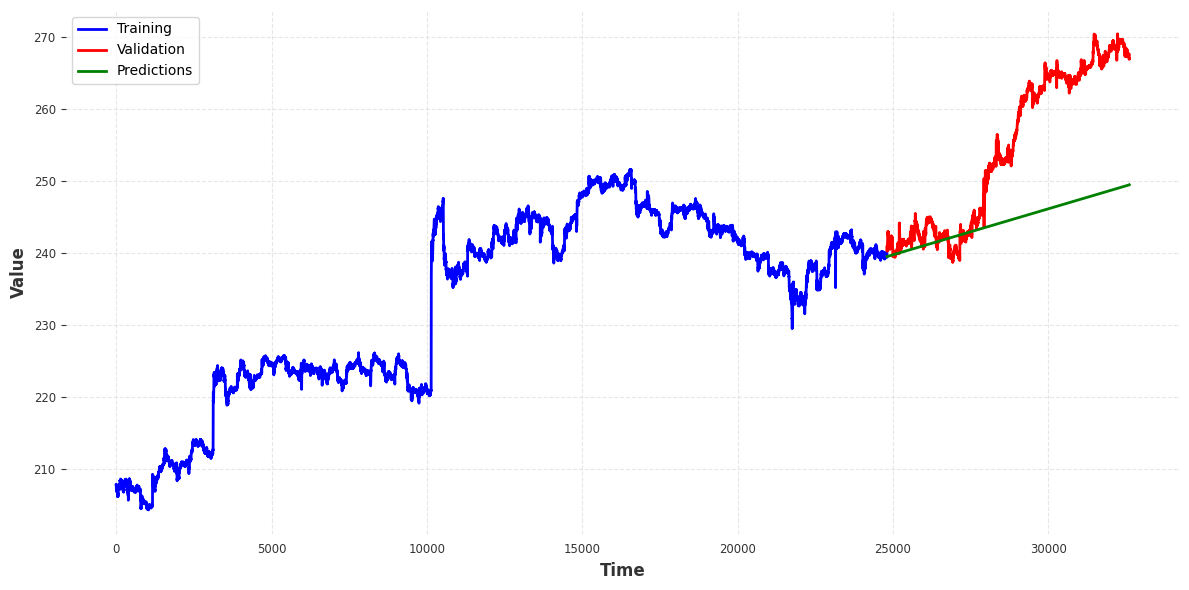

In [215]:
plot_series(
    [
        ts_train.pd_series(),                      
        (ts_val.pd_series(), ts_train.pd_series().shape[0]),                                    
        ([pred.pd_series()], 'overlapping', ts_train.pd_series().shape[0]) 
    ],
    colors=['blue', 'red', 'green'],
    labels=['Training', 'Validation', 'Predictions']
)